In [1]:
# Apply the Naïve Bayes algorithm to a real-world classification problem such as email spam detection, sentiment analysis, or disease diagnosis.
# Train and test the model, then evaluate its performance using a Confusion Matrix and related metrics such as accuracy, precision, recall, and F1-score.

[info] Loaded shape: (5172, 3002)

=== Performance Metrics ===
Accuracy : 0.9490
Precision: 0.8815
Recall   : 0.9520
F1-score : 0.9154

=== Classification Report ===
              precision    recall  f1-score   support

         ham       0.98      0.95      0.96       918
        spam       0.88      0.95      0.92       375

    accuracy                           0.95      1293
   macro avg       0.93      0.95      0.94      1293
weighted avg       0.95      0.95      0.95      1293



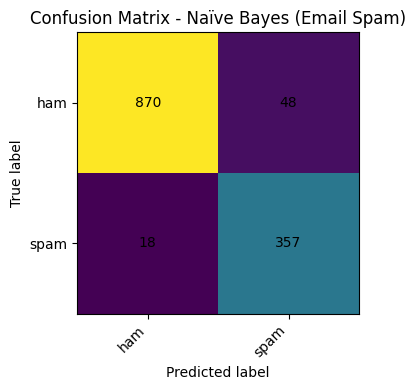

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
)

CSV_PATH = "emails.csv"  # put your file here

def load_csv_robust(path):
    """
    Try fast C-engine; if it fails, fall back to the Python engine and skip bad lines.
    """
    try:
        return pd.read_csv(path)
    except Exception as e:
        print("[info] Fast CSV parse failed, falling back (engine='python', onbadlines='skip').")
        # If there are malformed rows, skip them
        df = pd.read_csv(
            path,
            engine="python",
            onbadlines="skip",     # skip offending lines that have too many/few columns
            sep=",",               # enforce comma delimiter
            quotechar='"',         # handle quoted fields
        )
        return df

def main():
    # 1) Load
    df = load_csv_robust(CSV_PATH)
    print(f"[info] Loaded shape: {df.shape}")

    # 2) Clean columns
    # Common in this dataset: an ID-like column such as 'Email No.'—drop if present.
    drop_cols = ["Prediction", "Email No."]
    feature_cols = [c for c in df.columns if c not in drop_cols]

    # Keep only numeric features (coerce anything weird)
    X = df[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(0)

    # Labels
    y = pd.to_numeric(df["Prediction"], errors="coerce")
    # Drop rows where label is missing after coercion
    mask = y.notna()
    X = X.loc[mask].reset_index(drop=True)
    y = y.loc[mask].astype(int).reset_index(drop=True)

    # 3) Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    # 4) Train Naïve Bayes (Gaussian works well on count-like features too)
    model = GaussianNB()
    model.fit(X_train, y_train)

    # 5) Predict & metrics
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec  = recall_score(y_test, y_pred,  pos_label=1)
    f1   = f1_score(y_test, y_pred,      pos_label=1)

    print("\n=== Performance Metrics ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}\n")

    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=["ham","spam"]))

    # 6) Confusion Matrix
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix - Naïve Bayes (Email Spam)")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.xticks([0, 1], ["ham", "spam"], rotation=45, ha="right")
    plt.yticks([0, 1], ["ham", "spam"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
